In [ ]:
%%capture
!pip install datasets transformers huggingface_hub

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

sns.set_theme(style="whitegrid")
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IUI/yelp_reviews_restaurants_sampled_15000.csv')
print(df.shape)
df.head()

(15000, 16)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,user_id,review_stars,text,date,sentiment
0,oqy15jhe1lOXttEvd4Srog,El Poquito,8201 Germantown Ave,Philadelphia,PA,19118,40.073597,-75.202614,3.0,"{'WiFi': ""u'free'"", 'Smoking': ""u'no'"", 'Resta...","Mexican, Bars, Food, Nightlife, Restaurants",YSsNpQ_gn8pz95VCnFEg2g,1,Horrible service. Server didn't introduce hers...,2015-10-17 22:22:44,0
1,Vgw6AVZzI9_px1dYnEZ8lQ,Taste of Curry,10136 US Hwy 19,Port Richey,FL,34668,28.304623,-82.701031,4.0,"{'RestaurantsTakeOut': 'True', 'RestaurantsGoo...","Indian, Restaurants, Vegetarian, Buffets, Vega...",ni8Eo7Z6hMCrI1Ayov9Tmg,2,Nice and clean inside. Food took well over an...,2014-07-04 19:21:42,0
2,JPoLb8jZYc5e7WjI2coVkQ,"Love, Peace & Pho",2112 8th Ave S,Nashville,TN,37204,36.131466,-86.778591,3.5,"{'RestaurantsTableService': 'True', 'NoiseLeve...","Asian Fusion, Vietnamese, Restaurants",PG1Gf3xIoIeepJdXm96ZmQ,2,Where's the love? Not here! Our waiter - a tal...,2017-06-24 04:11:39,0
3,5qmNrtr0iNyhCk6ky3c97w,The Cheesecake Factory - Cool Springs,"1800 Galleria Blvd, Ste 1166",Franklin,TN,37067,35.958367,-86.813463,3.0,"{'NoiseLevel': ""u'average'"", 'WiFi': ""'no'"", '...","American (Traditional), Salad, Restaurants, Am...",cuMMdhzrACR4QVJVaCj2PA,1,Was very disappointed the service was terrible...,2015-04-11 01:47:37,0
4,yUndy-LC5huRJs75s0X1IA,Uncle Julio's,2011 S Lindbergh Blvd,Frontenac,MO,63131,38.626540,-90.405973,3.0,"{'Alcohol': ""u'full_bar'"", 'BusinessParking': ...","Tex-Mex, Restaurants, Mexican",v95s9p50rurFb1x2NmY4qQ,2,"Prime location in Frontenac, well-built and im...",2021-06-05 21:09:27,0


In [ ]:
review_list = []

for i, row in df_test.iterrows():
  review_list.append({"review_stars": row["review_stars"], "text": row["text"], "date": row["date"], "sentiment": row["sentiment"]})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

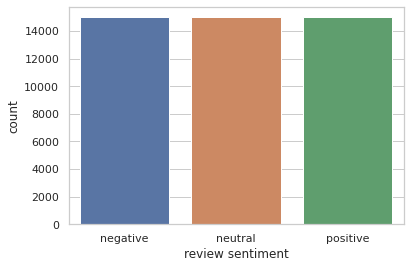

In [ ]:
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [ ]:
df_train = df.sample(frac=0.8,random_state=0)
df_test = df.drop(df_train.index)
print(df_train.shape, df_test.shape)

(12000, 16) (3000, 16)


In [ ]:
df_train = df_train[['sentiment', 'text']]
df_test = df_test[['sentiment', 'text']]
print(df_train.shape, df_test.shape)

(12000, 2) (3000, 2)


In [ ]:
df_test["text"].to_list()

In [ ]:
labels = df_train["sentiment"].to_list()
reviews = df_train["text"].to_list()

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
inputs = tokenizer(reviews, padding="max_length", truncation=True)

In [ ]:
import torch

class ReviewDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = ReviewDataset(inputs, labels)

In [ ]:
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 3)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=1000
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 36000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6750
  Number of trainable parameters = 66955779


Step,Training Loss
1000,0.629800
2000,0.490500
3000,0.400900
4000,0.356900
5000,0.286200
6000,0.212500


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=6750, training_loss=0.37589832673249424, metrics={'train_runtime': 4841.3756, 'train_samples_per_second': 22.308, 'train_steps_per_second': 1.394, 'total_flos': 1.4306734190592e+16, 'train_loss': 0.37589832673249424, 'epoch': 3.0})

In [ ]:
m = nn.Softmax(dim=1)
def to_check_result(test_encoding):
  input_ids = torch.tensor(test_encoding["input_ids"]).to(device)
  attention_mask = torch.tensor(test_encoding["attention_mask"]).to(device)
  with torch.no_grad():
    outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
  #print(outputs.logits)
  #print(m(outputs.logits).to("cpu").numpy())
  y = np.argmax(outputs[0].to("cpu").numpy())

  return y

In [ ]:
y_pred = []
for i in df_test["text"]:
  test_encoding = tokenizer(i, truncation=True, padding=True)
  input_ids = torch.tensor(test_encoding["input_ids"]).to(device)
  attention_mask = torch.tensor(test_encoding["attention_mask"]).to(device)
  op = to_check_result(test_encoding)
  y_pred.append(op)

In [ ]:
y_true = df_test["sentiment"].to_list()

              precision    recall  f1-score   support

    negative       0.85      0.82      0.83      3022
     neutral       0.71      0.76      0.73      2978
    positive       0.89      0.86      0.88      3000

    accuracy                           0.81      9000
   macro avg       0.82      0.81      0.81      9000
weighted avg       0.82      0.81      0.81      9000

[[2485  515   22]
 [ 435 2252  291]
 [  20  394 2586]]


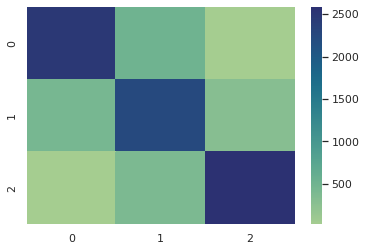

In [ ]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

target_names = ['negative', 'neutral', 'positive']
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), cmap="crest")

In [ ]:
trainer.save_model(".")

Saving model checkpoint to .
Configuration saved in ./config.json
Model weights saved in ./pytorch_model.bin


Load model

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IUI/yelp_reviews_restaurants_test.csv')
print(df.shape)

(10000, 16)


In [ ]:
from transformers import DistilBertForSequenceClassification
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained("/content/drive/MyDrive/IUI/model_15k")
model.to(device)

In [ ]:
sigmoid = nn.Sigmoid()
def get_prob(test_encoding):
  input_ids = torch.tensor(test_encoding["input_ids"]).to(device)
  attention_mask = torch.tensor(test_encoding["attention_mask"]).to(device)
  with torch.no_grad():
    outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
  y = np.argmax(outputs[0].to("cpu").numpy())
  sigmoid_vector = sigmoid(outputs.logits).to("cpu").numpy()[0]
  return y, sigmoid_vector[0], sigmoid_vector[2]

In [ ]:
y_pred = []
prob_neg_list = []
prob_pos_list = []
for i in df["text"]:
  test_encoding = tokenizer(i, truncation=True, padding=True)
  input_ids = torch.tensor(test_encoding["input_ids"]).to(device)
  attention_mask = torch.tensor(test_encoding["attention_mask"]).to(device)
  y, prob_neg, prob_pos = get_prob(test_encoding)
  y_pred.append(y)
  prob_neg_list.append(prob_neg)
  prob_pos_list.append(prob_pos)

In [ ]:
df["prob_neg"] = prob_neg_list
df["prob_pos"] = prob_pos_list

              precision    recall  f1-score   support

    negative       0.87      0.80      0.84      2030
     neutral       0.38      0.74      0.50      1128
    positive       0.98      0.85      0.91      6842

    accuracy                           0.83     10000
   macro avg       0.74      0.80      0.75     10000
weighted avg       0.89      0.83      0.85     10000

[[1631  385   14]
 [ 177  830  121]
 [  58  986 5798]]


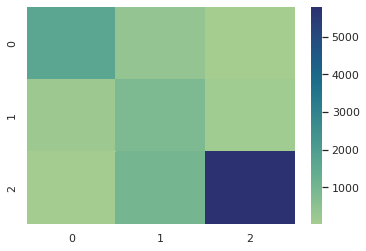

In [ ]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

y_true = df["sentiment"].to_list()

target_names = ['negative', 'neutral', 'positive']
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), cmap="crest")

In [ ]:
df.to_csv("yelp_reviews_restaurants_test.csv", index=False)